# **SkipGram Model on Custom Toy Data**

# Importing Required Libraries


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import nltk
from collections import Counter
from itertools import chain
from torch.utils.data import DataLoader, Dataset

# Download NLTK tokenizer if not available
nltk.download("punkt_tab")

# Device setup (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


## Dataset

In [2]:
def tokenize_data(sentences):
    """
    Tokenizes each sentence using NLTK's word tokenizer.
    """
    return [nltk.word_tokenize(sentence.lower()) for sentence in sentences]

In [4]:
toy_data = """I wish I was little bit taller
I wish I was a baller
She wore a small black dress to the party
The dog chased a big red ball in the park
He had a huge smile on his face when he won the race
The tiny kitten played with a fluffy toy mouse
The team celebrated their victory with a grand parade
She bought a small, delicate necklace for her sister
The mountain peak stood majestic and tall against the clear blue sky
The toddler took small, careful steps as she learned to walk
The house had a spacious backyard with a big swimming pool
He felt a sense of accomplishment after completing the challenging puzzle
The chef prepared a delicious, flavorful dish using fresh ingredients
The children played happily in the small, cozy room
The book had an enormous impact on readers around the world
The wind blew gently, rustling the leaves of the tall trees
She painted a beautiful, intricate design on the small canvas
The concert hall was filled with thousands of excited fans
The garden was adorned with colorful flowers of all sizes
I hope to achieve great success in my chosen career path
The skyscraper towered above the city, casting a long shadow
He gazed in awe at the breathtaking view from the mountaintop
The artist created a stunning masterpiece with bold brushstrokes
The baby took her first steps, a small milestone that brought joy to her parents
The team put in a tremendous amount of effort to win the championship
The sun set behind the horizon, painting the sky in vibrant colors
The professor gave a fascinating lecture on the history of ancient civilizations
The house was filled with laughter and the sound of children playing
She received a warm, enthusiastic welcome from the audience
The marathon runner had incredible endurance and determination
The child's eyes sparkled with excitement upon opening the gift
The ship sailed across the vast ocean, guided by the stars
The company achieved remarkable growth in a short period of time
The team worked together harmoniously to complete the project
The puppy wagged its tail, expressing its happiness and affection
She wore a stunning gown that made her feel like a princess
The building had a grand entrance with towering columns
The concert was a roaring success, with the crowd cheering and clapping
The baby took a tiny bite of the sweet, juicy fruit
The athlete broke a new record, achieving a significant milestone in her career
The sculpture was a masterpiece of intricate details and craftsmanship
The forest was filled with towering trees, creating a sense of serenity
The children built a small sandcastle on the beach, their imaginations running wild
The mountain range stretched as far as the eye could see, majestic and awe-inspiring
The artist's brush glided smoothly across the canvas, creating a beautiful painting
She received a small token of appreciation for her hard work and dedication
The orchestra played a magnificent symphony that moved the audience to tears
The flower bloomed in vibrant colors, attracting butterflies and bees
The team celebrated their victory with a big, extravagant party
The child's laughter echoed through the small room, filling it with joy
The sunflower stood tall, reaching for the sky with its bright yellow petals
The city skyline was dominated by tall buildings and skyscrapers
The cake was adorned with a beautiful, elaborate design for the special occasion
The storm brought heavy rain and strong winds, causing widespread damage
The small boat sailed peacefully on the calm, glassy lake
The artist used bold strokes of color to create a striking and vivid painting
The couple shared a passionate kiss under the starry night sky
The mountain climber reached the summit after a long and arduous journey
The child's eyes widened in amazement as the magician performed his tricks
The garden was filled with the sweet fragrance of blooming flowers
The basketball player made a big jump and scored a spectacular slam dunk
The cat pounced on a small mouse, displaying its hunting instincts
The mansion had a grand entrance with a sweeping staircase and chandeliers
The raindrops fell gently, creating a rhythmic patter on the roof
The baby took a big step forward, encouraged by her parents' applause
The actor delivered a powerful and emotional performance on stage
The butterfly fluttered its delicate wings, mesmerizing those who watched
The company launched a small-scale advertising campaign to test the market
The building was constructed with strong, sturdy materials to withstand earthquakes
The singer's voice was powerful and resonated throughout the concert hall
The child built a massive sandcastle with towers, moats, and bridges
The garden was teeming with a variety of small insects and buzzing bees
The athlete's muscles were well-developed and strong from years of training
The sun cast long shadows as it set behind the mountains
The couple exchanged heartfelt vows in a beautiful, intimate ceremony
The dog wagged its tail vigorously, a sign of excitement and happiness
The baby let out a tiny giggle, bringing joy to everyone around""".split('\n')


## Tokenization function


In [5]:
# Tokenize the dataset
tokenized_toy_data = tokenize_data(toy_data)

## Build Vocabulary

In [6]:
# Build vocabulary
counter = Counter(chain(*tokenized_toy_data))
vocab = {word: idx for idx, (word, _) in enumerate(counter.most_common(), start=1)}
vocab["<unk>"] = 0  # Assign index 0 to unknown token
index_to_word = {idx: word for word, idx in vocab.items()}


## Skip-Gram Data Preparation


In [7]:
# Prepare Skip-Gram data
CONTEXT_SIZE = 2
skip_data = []
for sentence in tokenized_toy_data:
    for i in range(CONTEXT_SIZE, len(sentence) - CONTEXT_SIZE):
        target = sentence[i]
        context = (
            [sentence[i - j - 1] for j in range(CONTEXT_SIZE)] +
            [sentence[i + j + 1] for j in range(CONTEXT_SIZE)]
        )
        skip_data.extend([(target, word) for word in context])

## Custom Dataset for PyTorch


In [8]:
# Custom Dataset
class SkipGramDataset(Dataset):
    def __init__(self, skip_data, vocab):
        self.data = [(vocab.get(target, vocab["<unk>"]), vocab.get(context, vocab["<unk>"])) for target, context in skip_data]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx][0], dtype=torch.long), torch.tensor(self.data[idx][1], dtype=torch.long)


## DataLoader


In [9]:
# DataLoader
BATCH_SIZE = 4
dataset = SkipGramDataset(skip_data, vocab)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [10]:
# Define Skip-Gram Model
class SkipGramModel(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super(SkipGramModel, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embed_dim)
        self.fc = nn.Linear(embed_dim, vocab_size)

    def forward(self, target):
        out = self.embeddings(target)
        out = self.fc(out)
        return out


## Model parameters


In [13]:
# Model Training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vocab_size = len(vocab)
embedding_dim = 24

model = SkipGramModel(vocab_size, embedding_dim).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
num_epochs = 50

## Function to train the Skip-Gram model


In [14]:
losses = []
for epoch in range(num_epochs):
    total_loss = 0
    for target, context in dataloader:
        target, context = target.to(device), context.to(device)
        optimizer.zero_grad()
        output = model(target)
        loss = criterion(output, context)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    losses.append(total_loss / len(dataloader))
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(dataloader):.4f}")

Epoch 1/50, Loss: 6.1410
Epoch 2/50, Loss: 5.9535
Epoch 3/50, Loss: 5.7849
Epoch 4/50, Loss: 5.6424
Epoch 5/50, Loss: 5.5241
Epoch 6/50, Loss: 5.4247
Epoch 7/50, Loss: 5.3392
Epoch 8/50, Loss: 5.2642
Epoch 9/50, Loss: 5.1971
Epoch 10/50, Loss: 5.1364
Epoch 11/50, Loss: 5.0810
Epoch 12/50, Loss: 5.0303
Epoch 13/50, Loss: 4.9833
Epoch 14/50, Loss: 4.9395
Epoch 15/50, Loss: 4.8984
Epoch 16/50, Loss: 4.8600
Epoch 17/50, Loss: 4.8234
Epoch 18/50, Loss: 4.7888
Epoch 19/50, Loss: 4.7559
Epoch 20/50, Loss: 4.7245
Epoch 21/50, Loss: 4.6946
Epoch 22/50, Loss: 4.6658
Epoch 23/50, Loss: 4.6378
Epoch 24/50, Loss: 4.6113
Epoch 25/50, Loss: 4.5852
Epoch 26/50, Loss: 4.5604
Epoch 27/50, Loss: 4.5361
Epoch 28/50, Loss: 4.5128
Epoch 29/50, Loss: 4.4900
Epoch 30/50, Loss: 4.4681
Epoch 31/50, Loss: 4.4465
Epoch 32/50, Loss: 4.4256
Epoch 33/50, Loss: 4.4050
Epoch 34/50, Loss: 4.3851
Epoch 35/50, Loss: 4.3657
Epoch 36/50, Loss: 4.3467
Epoch 37/50, Loss: 4.3281
Epoch 38/50, Loss: 4.3101
Epoch 39/50, Loss: 4.

## Plot Loss


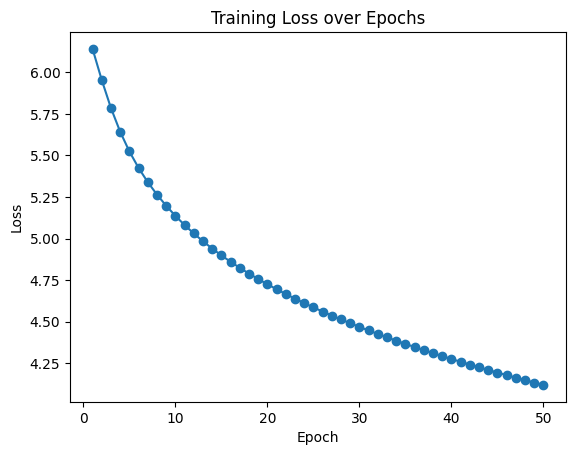

In [15]:
import matplotlib.pyplot as plt
# Plot Loss
plt.plot(range(1, num_epochs + 1), losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.show()